This notebook presents a solution for Kaggle's dog breed identification challenge (https://www.kaggle.com/c/dog-breed-identification). <br> In this playground competition, a strictly canine subset of ImageNet dataset was provided. With 120 breeds of dogs and only a limited number training images per class made this classification problem a little challenging.
Since there are only around 100 training images on average per class, training a convolution network from scratch would result in overfitting the model to the training data. Hence, a better approach would be to use a model pretrained on Imagenet dataset. We can this model as a feature extracter then using this extracted features we can train a simple linear model like logistic regression or a small fully connected Neural network. This approach is called transfer learning.(More on transfer learning here - http://cs231n.github.io/transfer-learning)
As base model, I tried few different models like ResNet50, InceptionV3, Xception but found that Inception-ResNet-v2 (https://arxiv.org/abs/1602.07261) gave higher accuracy compated others. I have used Keras deep learning library on top on tensorflow. Keras makes life easy while prototyping and experimenting with different ideas.

In [1]:
import os
from os.path import exists

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook as tqdm
from mpl_toolkits.axes_grid1 import ImageGrid

from keras.applications.inception_resnet_v2 import InceptionResNetV2 , preprocess_input as inception_resnet_preprocessor
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, RMSprop, Adam

%matplotlib inline

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Read labels
#Labels.csv file has an id and breed for each image
labels = pd.read_csv('labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


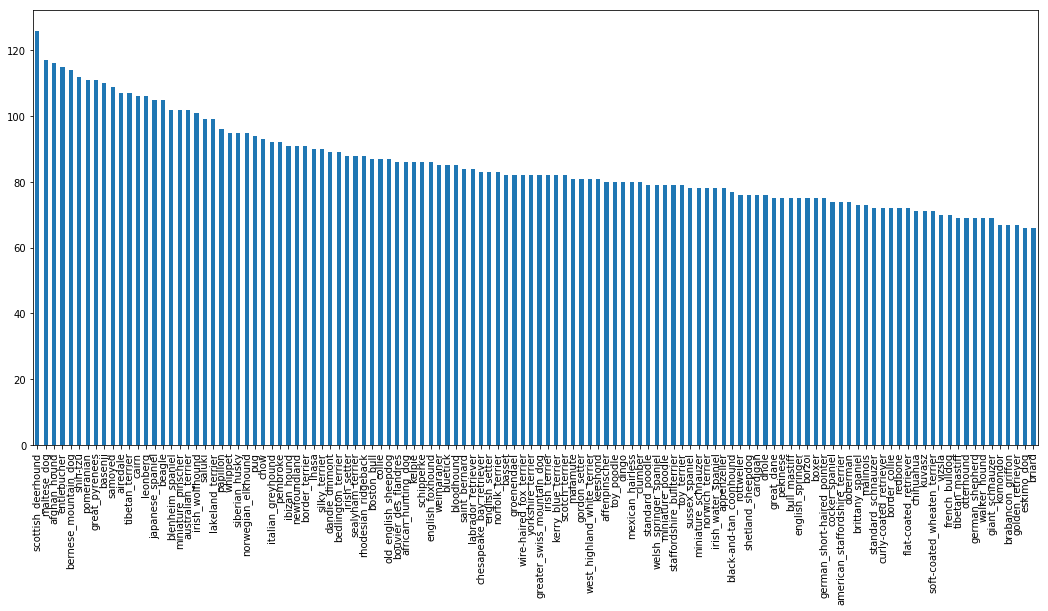

In [3]:
#Lets see the distribution images across breeds
plt.figure(figsize=(18, 8))
labels['breed'].value_counts().plot(kind='bar')

In [4]:
#Top 5 breeds
print("Top five breeds:")
print(labels['breed'].value_counts().head())

#Bottom 5 breeds
print()
print("Five rare breeds:")
print(labels['breed'].value_counts().tail())

Top five breeds:
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

Five rare breeds:
komondor             67
brabancon_griffon    67
golden_retriever     67
eskimo_dog           66
briard               66
Name: breed, dtype: int64


In [5]:
seed = 1986
image_size = 299
train_dir = 'train'
test_dir = 'test'

#encode labels
le = LabelEncoder()
train_labels = le.fit_transform(labels['breed'])
labels['class'] = train_labels
labels.head()

,id,breed,class
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49


In [6]:
#load training data
train = np.array([img_to_array(load_img(join(train_dir, id+'.jpg'), target_size=(image_size, image_size))) 
                  for id in tqdm(labels['id'].values.tolist())])
print("Training shape: {}".format(train.shape))

HBox(children=(IntProgress(value=0, max=10222), HTML(value='')))


Training shape: (10222, 299, 299, 3)


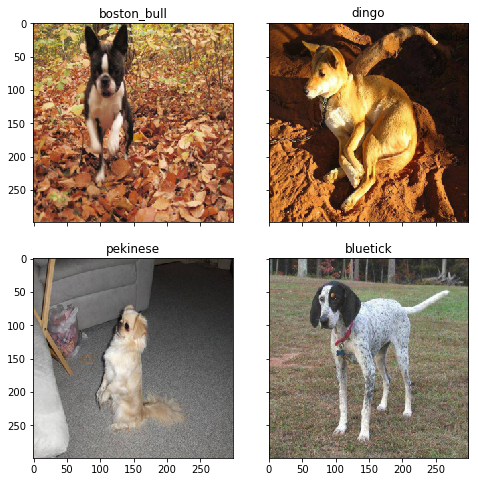

In [7]:
#Let see few dog images
fig = plt.figure(1, figsize=(8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.5)

for i in range(4):
    grid[i].imshow(train[i].astype(np.uint8))
    grid[i].set_title(le.classes_[train_labels[i]])

In [8]:
#split the training data into training and validation set
x_train, x_val, y_train, y_val = train_test_split(train, train_labels, test_size=0.2, 
                                                  random_state=seed, stratify= train_labels)
print("Training features shape: {}".format(x_train.shape))
print("Validation features shape: {}".format(x_val.shape))

Training features shape: (8177, 299, 299, 3)
Validation features shape: (2045, 299, 299, 3)


In [9]:
#one hot encoding of labels
NUM_OF_CLASSES = 120
y_train = to_categorical(y_train, num_classes=NUM_OF_CLASSES)
y_val = to_categorical(y_val, num_classes=NUM_OF_CLASSES)
print(y_train.shape)
print(y_val.shape)

(8177, 120)
(2045, 120)


In [10]:
#Create inceptionresnet base model to generate features
inceptionresnetv2_model = InceptionResNetV2(include_top=False, weights='imagenet', pooling='avg')

In [11]:
#Extract feetures for training and validation images and save it into a file
inceptionresnetv2_features_file = 'inceptionresnetv2_features.npy'
inceptionresnetv2_validationfeatures_file = 'inceptionresnetv2_validationfeatures.npy'

if exists(inceptionresnetv2_features_file):
    inceptionresnetv2_features = np.load(inceptionresnetv2_features_file)
    inceptionresnetv2_validationfeatures = np.load(inceptionresnetv2_validationfeatures_file)
else:
    inceptionresnetv2_features = inceptionresnetv2_model.predict(inception_resnet_preprocessor(x_train))
    inceptionresnetv2_validationfeatures = inceptionresnetv2_model.predict(inception_resnet_preprocessor(x_val))
    np.save(inceptionresnetv2_features_file, inceptionresnetv2_features)
    np.save(inceptionresnetv2_validationfeatures_file, inceptionresnetv2_validationfeatures)
    
print('Generated features shape: {}'.format(inceptionresnetv2_features.shape))
print('Generated validation featurtes shape: {}'.format(inceptionresnetv2_validationfeatures.shape))

Generated features shape: (8177, 1536)
Generated validation featurtes shape: (2045, 1536)


In [12]:
#create a top model
top_model = Sequential()

#after global average pooling last hideen layer of our base model gives 1536-D vector for each image
top_model.add(Dense(1024, input_dim=1536, activation='relu'))
top_model.add(Dropout(0.7))
top_model.add(Dense(120, activation='softmax'))

In [13]:
from keras.callbacks import EarlyStopping, Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

In [14]:
top_model.compile(optimizer=SGD(lr=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
epochs =100
batch_size = 64

In [16]:
top_model.fit(inceptionresnetv2_features, y_train, batch_size=batch_size, epochs=epochs,
              shuffle=True, callbacks=[early_stopping], validation_data=(inceptionresnetv2_validationfeatures, y_val))


Train on 8177 samples, validate on 2045 samples
Epoch 1/100
8177/8177 [==============================] - 2s 208us/step - loss: 2.4100 - acc: 0.5875 - val_loss: 0.4508 - val_acc: 0.9042
Epoch 2/100
8177/8177 [==============================] - 1s 66us/step - loss: 0.5011 - acc: 0.8815 - val_loss: 0.3061 - val_acc: 0.9130
Epoch 3/100
8177/8177 [==============================] - 1s 68us/step - loss: 0.3933 - acc: 0.8951 - val_loss: 0.2767 - val_acc: 0.9115
Epoch 4/100
8177/8177 [==============================] - 1s 67us/step - loss: 0.3387 - acc: 0.9038 - val_loss: 0.2675 - val_acc: 0.9203
Epoch 5/100
8177/8177 [==============================] - 1s 67us/step - loss: 0.3124 - acc: 0.9062 - val_loss: 0.2666 - val_acc: 0.9174
Epoch 6/100
8177/8177 [==============================] - 1s 68us/step - loss: 0.2948 - acc: 0.9104 - val_loss: 0.2632 - val_acc: 0.9174
Epoch 7/100
8177/8177 [==============================] - 1s 66us/step - loss: 0.2862 - acc: 0.9113 - val_loss: 0.2694 - val_acc: 0.9164

We can see that after 12 epochs the validation accuracy is around 92% which gave Kaggle public LB score of 0.25 (in top 33% on public learboard). To improve the accuracy of the model further, we could try image augmentation and ensemble of few different base models. 

predicted breed: yorkshire_terrier


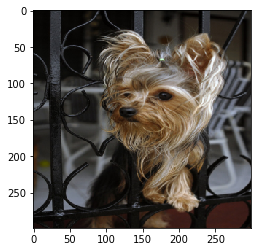

In [17]:
#Let's test model on a sample image 
pil_image = load_img('images/Yorkshire_terrier_08346.jpg', target_size=(image_size, image_size))
image = img_to_array(pil_image)
image = np.expand_dims(image, axis=0)
image_features = inceptionresnetv2_model.predict(inception_resnet_preprocessor(image))
prediction = top_model.predict(image_features)
plt.imshow(pil_image)
print('predicted breed: {}'.format(le.classes_[np.argmax(prediction, axis=1)[0]]))

In [ ]:
#Load test data and generate submission file for test data
test_images = os.listdir(test_dir)
test = np.array([img_to_array(load_img(join(test_dir, img), target_size=(image_size, image_size))) 
                  for img in tqdm(test_images)])
print("Test shape: {}".format(test.shape))
test_features = inceptionresnetv2_model.predict(inception_resnet_preprocessor(test))
test_predictions = top_model.predict(test_features)
result = pd.DataFrame(test_predictions)
result.columns = labels['breed'].sort_values().unique()
result['id'] = [img.split('.')[0] for img in test_images]
cols = result.columns.tolist()
cols = cols[-1:] + cols[:-1]
result = result[cols]
result.to_csv('submission_inceptionresnet.csv', index=False)